_This notebook contains code and comments from Section 3.1 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

---

## 3.1 Base estimators for heterogeneous ensembles 

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(600, noise=0.25, random_state=13)
X, Xval, y, yval = train_test_split(X, y, test_size=0.25)        # Set aside 25% of data for validation
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.25)  # Set aside a further 25% of data for hold-out test

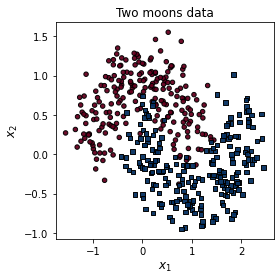

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from visualization import plot_2d_data

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
plot_2d_data(ax, X, y, alpha=0.95, xlabel='$x_1$', ylabel='$x_2$', title='Two moons data', colormap='RdBu');
fig.tight_layout()

plt.savefig('./figures/CH03_F02_Kunapuli.png', format='png', dpi=300, bbox_inches='tight');

---

### 3.1.1	Fitting base estimators
For this scenario, we use six popular machine-learning algorithms, all of which are available in scikit-learn: [``DecisionTreeClassifier``](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [``SVC``](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), [``GaussianProcessClassifier``](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html), [``KNeighborsClassifier``](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [``RandomForestClassifier``](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and [``GaussianNB``](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html). 

**Listing 3.1**: Fitting different base estimators

In [3]:
# --- Some code to suppress warnings generated due to versioning changes in sklearn and scipy
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
# --- Can be removed at a future date

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

estimators = [('dt', DecisionTreeClassifier(max_depth=5)),
              ('svm', SVC(gamma=1.0, C=1.0, probability=True)),
              ('gp', GaussianProcessClassifier(RBF(1.0))),
           	  ('3nn', KNeighborsClassifier(n_neighbors=3)),
              ('rf',RandomForestClassifier(max_depth=3, n_estimators=25)),
              ('gnb', GaussianNB())]

def fit(estimators, X, y):
    for model, estimator in estimators:
        estimator.fit(X, y)
    return estimators

In [4]:
estimators = fit(estimators, Xtrn, ytrn)

We visualize how each base estimator behaves on our data set. Using different base learning algorithms allows the ensemble to train naturally diverse base estimators.

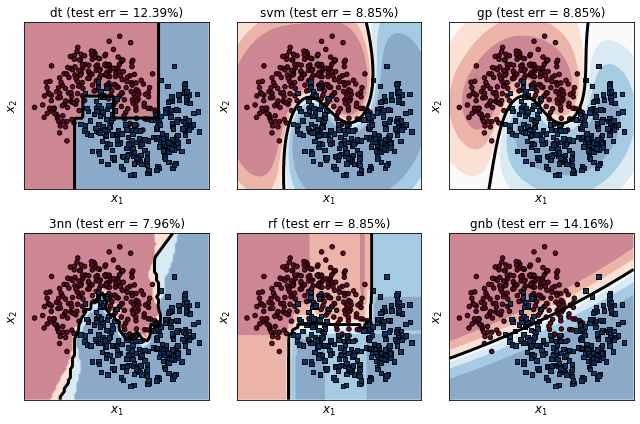

In [5]:
from sklearn.metrics import accuracy_score
from visualization import plot_2d_classifier

%matplotlib inline

n_estimators = len(estimators)
nrows, ncols = n_estimators // 3, 3

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9, 6))
for i, (model, estimator) in enumerate(estimators):
    r, c = divmod(i, 3)

    # Compute the test error
    tst_err = 1 - accuracy_score(ytst, estimator.predict(Xtst))

    title = '{0} (test err = {1:4.2f}%)'.format(model, tst_err*100)  
    plot_2d_classifier(ax[r, c], X, y, colormap='RdBu', alpha=0.5,
                       predict_function=estimator.predict_proba, predict_proba=True,
                       xlabel='$x_1$', ylabel='$x_2$', title=title)   
    ax[r, c].set_xticks([])
    ax[r, c].set_yticks([])

fig.tight_layout()
plt.savefig('./figures/CH03_F04_Kunapuli.png', dpi=300, bbox_inches='tight');

---

### 3.1.2	Individual predictions of base estimators

Given that we have six base estimators, each test example will have six predictions, one corresponding to each base estimator.

**Listing 3.2**: Individual predictions of base estimators

The function ``predict_individual`` has a flag ``proba``. When we set ``proba=False``, ``predict_individual`` returns the predicted labels according to each estimator; the predicted labels take the values ``y_pred=0`` or ``y_pred=1``, and tell us that the estimator has predicted that example to belong to Class 0 or Class 1 respectively. 

When we set ``proba=True``, however, each estimator will return the class prediction probabilities instead via each base estimator’s ``predict_proba()`` function: 

            y[:, i] = estimator.predict_proba(X)[:, 1]

In [6]:
import numpy as np

def predict_individual(X, estimators, proba=False):
    n_estimators = len(estimators)
    n_samples = X.shape[0] 

    y = np.zeros((n_samples, n_estimators))
    for i, (model, estimator) in enumerate(estimators):
        if proba:
            y[:, i] = estimator.predict_proba(X)[:, 1]  
        else:
            y[:, i] = estimator.predict(X)              
    return y

First, test this function with ``proba=False``, to get label predictions directy.

In [7]:
y_individual = predict_individual(Xtst, estimators, proba=False)
y_individual

array([[1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0.],
       [0.

Each row contains six predictions, each one corresponding to the prediction of each base estimator. We sanity check our predictions: Xtst has 113 test examples, and y_individual has six predictions for each of them, which gives us a 113 x 6 array of predictions.

In [8]:
print(Xtst.shape)
print(y_individual.shape)

(113, 2)
(113, 6)


Next, test this function with ``proba=True``, to get prediction probabilities instead

In [9]:
y_individual = predict_individual(Xtst, estimators, proba=True)
np.set_printoptions(precision=2)
y_individual

array([[1.  , 0.98, 0.88, 1.  , 0.88, 0.99],
       [1.  , 0.99, 0.94, 1.  , 0.99, 1.  ],
       [0.13, 0.01, 0.11, 0.  , 0.27, 0.54],
       [0.  , 0.01, 0.13, 0.  , 0.02, 0.  ],
       [0.  , 0.  , 0.06, 0.  , 0.02, 0.  ],
       [1.  , 1.  , 0.94, 1.  , 0.98, 1.  ],
       [1.  , 0.93, 0.79, 1.  , 0.88, 0.96],
       [0.  , 0.01, 0.08, 0.  , 0.02, 0.  ],
       [0.05, 0.  , 0.07, 0.  , 0.2 , 0.33],
       [1.  , 0.99, 0.9 , 1.  , 0.99, 1.  ],
       [1.  , 0.99, 0.9 , 1.  , 0.9 , 0.94],
       [0.05, 0.22, 0.37, 1.  , 0.24, 0.08],
       [0.  , 0.  , 0.06, 0.  , 0.15, 0.08],
       [1.  , 1.  , 0.95, 1.  , 0.99, 1.  ],
       [0.  , 0.02, 0.19, 0.  , 0.24, 0.46],
       [0.05, 0.  , 0.07, 0.  , 0.28, 0.33],
       [0.  , 0.01, 0.08, 0.  , 0.18, 0.01],
       [0.  , 0.  , 0.09, 0.  , 0.12, 0.13],
       [1.  , 0.99, 0.91, 1.  , 0.88, 0.98],
       [0.05, 0.04, 0.14, 0.  , 0.13, 0.04],
       [1.  , 0.98, 0.87, 1.  , 0.88, 0.98],
       [0.  , 0.  , 0.05, 0.  , 0.11, 0.03],
       [1.